In [47]:
#----------------------------------------------
# Imports from this package:
from _STOFS import get_station_nowcast_data
from _STOFS import get_station_data
from _GFS import fetch_gfs_Nowcast_data
from _GFS import fetch_gfs_Forecast_data
from _obs import fetch_coops_multistation_df
from stofs_run import StofsRun
#----------------------------------------------

import warnings
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
from datetime import datetime, timedelta, timezone
import searvey
from searvey.coops import get_coops_stations
from searvey._coops_api import fetch_coops_station
import tempfile
import pygrib
import math
from typing import List
from stormevents.nhc import nhc_storms, VortexTrack
from stormevents import StormEvent

In [3]:
# Time and location
date_range = ['20240910','20240912']  
landfall_time_step = 70 # hours after start date from the date range input
Hours_before_landfall = 48 # For reading Forecast data
Region = (-96, -94, 28, 30)  # select 'NaN' if you want to use region based on storm track or use (longitude_min, longitude_max, latitude_min, latitude_max)  

# NHC storm info.
Event_name = 'Hurricane FRANCINE'
storm_name = 'francine'
storm_year = 2024
advisory = 'BEST' #'OFCL' for latest forecast and change it to 'BEST' if best track is available 

## Model data

In [4]:
# Specify model runs.
stofs_2d = StofsRun('noaa-gestofs-pds', 
                    '', 
                    'stofs_2d_glo', 
                    {"default":"points.cwl", "noanomaly":"points.cwl.noanomaly", 
                     "velocity":"points.cwl.vel", "autoval":"points.autoval.cwl"}, 
                    ['00','06','12','18'], 
                    60)
stofs_3d = StofsRun('noaa-nos-stofs3d-pds', 
                    'STOFS-3D-Atl', 
                    'stofs_3d_atl', 
                    {"default":"points.cwl",  
                     "tsv":"points.cwl.temp.salt.vel", "autoval":"points.autoval.cwl"}, 
                    ['12'], 
                    240)

In [5]:
nowcast_2d = stofs_2d.get_station_nowcast(date_range)
nowcast_2d_noanomaly = stofs_2d.get_station_nowcast(date_range, output_type="noanomaly")
nowcast_3d = stofs_3d.get_station_nowcast(date_range)

## Observational data

* How stations are selected in other notebooks:
    1.  All COOPS stations from defined region using searvey function get_coops_stations(...)
    2.  Filtered to active and desired type (e.g., waterlevel)
    3.  Retained if archived in model, separately by different model runs, and downloaded.
* I propose to pool observations between different model runs (STOFS-2D vs STOFS-3D) to avoid duplicate downloads, at the cost of possibly fetching stations that aren't archived in the model, or slightly longer periods of data.

In [6]:
if Region == 'NaN':
   bbox = storm_track.wind_swaths(wind_speed=50)[advisory][track_date]
else:
   bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
buffered_bbox = bbox.buffer(0.8)  

In [7]:
station_list = searvey.get_coops_stations(region=buffered_bbox, metadata_source='main')

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:07<00:00,  3.88it/s]


#### Get stations and times for water level stations

In [8]:
waterlevel_stations = station_list[(station_list['status'] == 'active') & 
                                   (station_list['station_type'] == 'waterlevels')]

In [9]:
waterlevel_start_time = min([nowcast_3d.time.min().data, nowcast_2d.time.min().data])
waterlevel_end_time = max([nowcast_3d.time.max().data, nowcast_2d.time.max().data])

#### Download and concatenate the data.

In [48]:
waterlevel_obs = fetch_coops_multistation_df(waterlevel_stations.index,
                                             waterlevel_start_time,
                                             waterlevel_end_time,
                                             'water_level',
                                             datum='NAVD')
print(waterlevel_obs)

8771013: Encountered an error response for {'station_id': '8771013', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8771013&product=water_level&datum=NAVD&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&begin_date=20240910%2000%3A00&end_date=20240913%2000%3A00'), 'client': <httpx.Client object at 0x147a1ff3a480>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x147a281d0980>, 'product': <COOPS_Product.WATER_LEVEL: 'water_level'>, 'redirect': True}!
-->  The supported Datum values are: MHHW, MHW, MTL, MSL, MLW, MLLW, 
COOPS-8771013: No data. Creating a dummy dataframe
8771367: Encountered an error response for {'station_id': '8771367', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8771367&product=water_level&datum=NAVD&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&begin_date=20240910%2000%3A00&end_date=20240913%2000%3A00'), 'client': <httpx.Client o

True


In [11]:
print(waterlevel_obs)

                                   value  sigma    flags quality
station time                                                    
8767961 2024-09-10 00:00:00+00:00  0.130  0.002  0,0,0,0       v
        2024-09-10 00:06:00+00:00  0.131  0.002  0,0,0,0       v
        2024-09-10 00:12:00+00:00  0.129  0.002  0,0,0,0       v
        2024-09-10 00:18:00+00:00  0.130  0.001  0,0,0,0       v
        2024-09-10 00:24:00+00:00  0.130  0.001  0,0,0,0       v
...                                  ...    ...      ...     ...
8774230 2024-09-12 23:36:00+00:00  0.871  0.001  0,0,0,0       v
        2024-09-12 23:42:00+00:00  0.872  0.000  0,0,0,0       v
        2024-09-12 23:48:00+00:00  0.872  0.000  0,0,0,0       v
        2024-09-12 23:54:00+00:00  0.869  0.001  0,0,0,0       v
        2024-09-13 00:00:00+00:00  0.869  0.001  0,0,0,0       v

[14420 rows x 4 columns]


## Cast model data into same format as obs

In [12]:
def extract_model_station_df(ds, station_id_list, data_var='zeta'):
    
    result = pd.DataFrame()
    
    for nos_id in station_id_list:
    
        #print(f"Fetching model data for NOS ID {nos_id}")
    
        # Find the model station names that match this NOS ID.
        obs_name_in_model = [nos_id in nm.decode('utf-8') 
                             for nm in ds.station_name[0,:].data]
            
        # Check that only one model station matchis this ID.
        if np.sum(obs_name_in_model) > 1:
            print(f"Warning: more than one model station matches NOS ID {nos_id}")
        elif np.sum(obs_name_in_model) == 0:
            print(f"Warning: no model station matches for NOS ID {nos_id}")
        else:
            # Check if the name for this station is constant in time.
            if len(pd.unique(ds.station_name[:,obs_name_in_model].squeeze().data)) > 1:
                print(f"Warning: model station name is not constant for NOS ID {nos_id}:")
                print(pd.unique(ds.station_name[:,obs_name_in_model].squeeze().data))
                
            # If available, concatenate the data with other stations.
            station_df = ds[data_var][:,obs_name_in_model]\
                .assign_coords(station=np.array([nos_id]))\
                .to_dataframe(dim_order=('station', 'time'))
            try:
                result = pd.concat(
                    [result, station_df],
                    axis=0,
                    join="outer",
                    ignore_index=False,
                    sort=False
                )
            except:
                print(f"Warning: cannot concatenate station data frame for NOS ID {nos_id}: Skipping.")
                continue
                
    return result
    

In [13]:
waterlevel_nowcast_2d = extract_model_station_df(nowcast_2d, waterlevel_stations.index)

In [14]:
waterlevel_nowcast_2d_noanomaly = extract_model_station_df(nowcast_2d_noanomaly, waterlevel_stations.index)

In [15]:
waterlevel_nowcast_3d = extract_model_station_df(nowcast_3d, waterlevel_stations.index)

## Plot figures

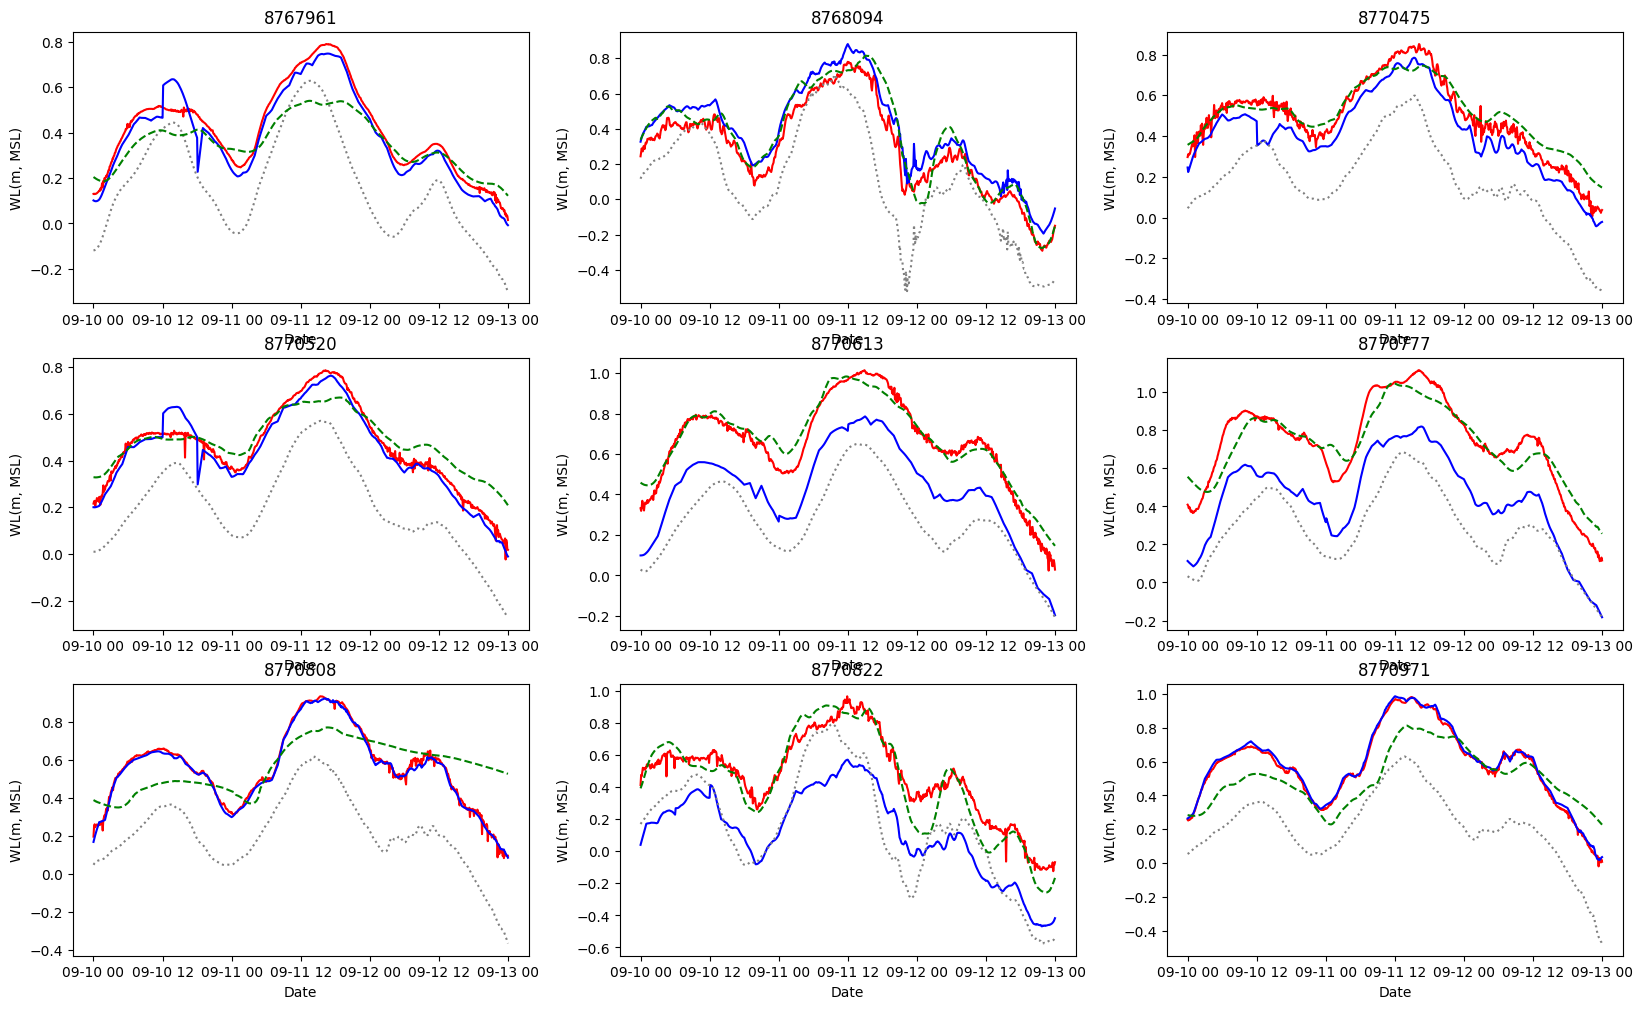

In [16]:
# Define the number of rows and columns for subplots (2 columns)
num_rows = 3
num_cols = 3

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))
axs = axs.flatten()

for iax, ax in enumerate(axs):
    
    if iax >= len(waterlevel_obs.index.levels[0]):
        break
    else:
        nos_id = waterlevel_obs.index.levels[0][iax]
        
    ax.plot(waterlevel_obs.loc[nos_id].index, waterlevel_obs.loc[nos_id]['value'], 
            label='Observation',color='red')
    try:
        ax.plot(waterlevel_nowcast_2d.loc[nos_id].index, 
                waterlevel_nowcast_2d.loc[nos_id]['zeta'],
                label='Nowcast (STOFS-2D-Global-bias corrected)', color='blue')
        ax.plot(waterlevel_nowcast_2d_noanomaly.loc[nos_id].index, 
                waterlevel_nowcast_2d_noanomaly.loc[nos_id]['zeta'], 
                label='Nowcast (STOFS-2D-Global)', color='gray', linestyle='dotted')
    except:
        print(f"Cannot plot STOFS-2D nowcast data for NOS ID {nos_id}")
    try:
        ax.plot(waterlevel_nowcast_3d.loc[nos_id].index, 
                waterlevel_nowcast_3d.loc[nos_id]['zeta'], 
                label='Nowcast (STOFS-3D-Atlantic)', color='green', linestyle='dashed')
    except:
        print(f"Cannot plot STOFS-3D nowcast data for NOS ID {nos_id}")
        
    ax.set_xlabel('Date')
    ax.set_ylabel('WL(m, MSL)')
    ax.set_title(nos_id)
    
plt.show()

# Compare GFS meteorology data with observations
10-m wind and surface pressure.

We want plots of observations and model for wind speed and surface pressure. 
Lines on figure:
* Observation
* GFS (straight from fetch_gfs_Forecast_data or fetch_gfs_Nowcast_data)
* HRRR-GFS (wind_concat)

In [39]:
# Get list of met stations from main list.
met_stations = station_list[(station_list['status'] == 'active') & 
                            (station_list['station_type'] == 'met')]

In [ ]:
# Download observations using searvey.
wind_obs = fetch_coops_multistation_df(
    met_stations.index,
    waterlevel_start_time,
    waterlevel_end_time,
    'wind',
    interval='h'
)
pressure_obs = fetch_coops_multistation_df(
    met_stations.index,
    waterlevel_start_time,
    waterlevel_end_time,
    'air_pressure',
    interval='h'
)

In [55]:
# Get GFS data (STOFS-2D forcing)
# Each of these outputs is a pandas data frame with one column per station and 
# a dummy index (0, 1, ..., N-1).
u_gfs_nowcast, v_gfs_nowcast, p_gfs_nowcast, t_gfs_nowcast = fetch_gfs_Nowcast_data(
    pd.to_datetime(waterlevel_start_time).strftime('%Y%m%d'), 
    pd.to_datetime(waterlevel_end_time).strftime('%Y%m%d'), 
    ['00', '06', '12', '18'], 
    met_stations.reset_index(), 
    6
) 

20240910
gfs.20240910/00/atmos/gfs.t00z.sfluxgrbf000.grib2
0
{'8767961': (array([510]),), '8768094': (array([513]),), '8770475': (array([513]),), '8770613': (array([514]),), '8770777': (array([514]),), '8770808': (array([515]),), '8770822': (array([514]),), '8770971': (array([516]),), '8771013': (array([516]),), '8771341': (array([517]),), '8771450': (array([517]),), '8771486': (array([517]),), '8771972': (array([519]),), '8772471': (array([521]),), '8773037': (array([525]),), '8773146': (array([522]),), '8773259': (array([523]),), '8773701': (array([525]),), '8773767': (array([525]),), '8774230': (array([527]),)}
gfs.20240910/00/atmos/gfs.t00z.sfluxgrbf001.grib2
1
gfs.20240910/00/atmos/gfs.t00z.sfluxgrbf002.grib2
2
gfs.20240910/00/atmos/gfs.t00z.sfluxgrbf003.grib2
3
gfs.20240910/00/atmos/gfs.t00z.sfluxgrbf004.grib2
4
gfs.20240910/00/atmos/gfs.t00z.sfluxgrbf005.grib2
5
gfs.20240910/06/atmos/gfs.t06z.sfluxgrbf000.grib2
0
gfs.20240910/06/atmos/gfs.t06z.sfluxgrbf001.grib2
1
gfs.20240910/0

In [58]:
# Get HRRR data.
u_hrrr_nowcast, v_hrrr_nowcast, p_hrrr_nowcast = fetch_saved_HRRR_Nowcast_data(
    '', 
    modelname, 
    'STOFS-3D-Atl', 
    '', 
    'noaa-nos-stofs3d-pds', 
    [pd.to_datetime(waterlevel_start_time).strftime('%Y%m%d'),
     pd.to_datetime(waterlevel_end_time).strftime('%Y%m%d')], 
    met_stations.reset_index(), 
    steps
)

,8767961,8768094,8770475,8770613,8770777,8770808,8770822,8770971,8771013,8771341,8771450,8771486,8771972,8772471,8773037,8773146,8773259,8773701,8773767,8774230
0,-2.71,-2.62,-4.38,-3.03,-3.82,-4.09,-4.32,-5.57,-4.31,-6.20,-5.78,-4.91,-5.77,-7.21,-5.20,-5.10,-5.06,-6.40,-7.64,-5.98
1,-2.58,-1.88,-3.91,-2.64,-3.31,-4.35,-3.89,-6.38,-5.15,-6.98,-6.65,-5.59,-5.79,-7.05,-5.42,-4.07,-5.28,-6.54,-7.80,-6.35
2,-2.87,-2.34,-3.65,-3.11,-3.13,-4.57,-3.53,-7.43,-6.54,-8.21,-7.99,-6.83,-6.37,-8.01,-5.00,-3.34,-4.69,-5.94,-7.07,-5.93
3,-2.90,-2.17,-3.90,-2.83,-3.42,-4.21,-3.94,-7.08,-6.81,-8.19,-8.20,-7.41,-6.71,-7.99,-4.90,-3.43,-4.86,-5.81,-7.26,-6.08
4,-2.95,-2.72,-3.93,-2.25,-2.97,-4.06,-4.08,-6.30,-5.94,-7.49,-7.53,-6.77,-6.75,-7.53,-5.31,-3.59,-5.43,-6.25,-7.82,-6.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2.02,2.67,2.25,1.39,2.62,1.81,1.38,-0.24,-2.11,-1.31,-2.05,-1.12,0.19,1.52,-2.09,0.51,-2.09,-0.71,-1.20,-1.16
92,2.35,2.99,2.57,0.01,2.58,1.84,1.70,-0.41,-2.70,-1.19,-1.85,-0.90,0.10,1.43,-2.04,0.48,-2.46,-0.68,-1.25,-1.40
93,2.52,3.14,2.02,-2.24,2.36,1.29,1.45,-0.71,-3.29,-1.21,-2.00,-1.12,0.41,1.46,-2.20,0.24,-2.98,-1.02,-1.42,-1.77
94,2.73,3.02,1.62,-4.11,1.09,0.99,1.16,-0.62,-3.07,-0.84,-1.53,-1.09,0.87,1.16,-2.41,-0.05,-3.13,-1.49,-1.69,-2.20


In [59]:
def read_STOFS_from_s3(bucket_name, key):
    """
    Function to read a STOFS nc files from an S3 bucket.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds

In [60]:
forecast_3d = read_STOFS_from_s3('noaa-nos-stofs3d-pds',
                                 'STOFS-3D-Atl/stofs_3d_atl.20241201/schout_adcirc_20241130.nc')

In [70]:
forecast_3d.time.data

array(['2024-11-30T13:00:00.000000000', '2024-11-30T14:00:00.000000000',
       '2024-11-30T15:00:00.000000000', '2024-11-30T16:00:00.000000000',
       '2024-11-30T17:00:00.000000000', '2024-11-30T18:00:00.000000000',
       '2024-11-30T19:00:00.000000000', '2024-11-30T20:00:00.000000000',
       '2024-11-30T21:00:00.000000000', '2024-11-30T22:00:00.000000000',
       '2024-11-30T23:00:00.000000000', '2024-12-01T00:00:00.000000000',
       '2024-12-01T01:00:00.000000000', '2024-12-01T02:00:00.000000000',
       '2024-12-01T03:00:00.000000000', '2024-12-01T04:00:00.000000000',
       '2024-12-01T05:00:00.000000000', '2024-12-01T06:00:00.000000000',
       '2024-12-01T07:00:00.000000000', '2024-12-01T08:00:00.000000000',
       '2024-12-01T09:00:00.000000000', '2024-12-01T10:00:00.000000000',
       '2024-12-01T11:00:00.000000000', '2024-12-01T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [66]:
hrrr_air = read_STOFS_from_s3(
    'noaa-nos-stofs3d-pds',
    'STOFS-3D-Atl/stofs_3d_atl.20241201/rerun/stofs_3d_atl.t12z.hrrr.air.nc'
)

In [72]:
print(hrrr_air)
print(hrrr_air.data_vars)
print(hrrr_air.time[0:2])
print(hrrr_air.time[-1])
print(hrrr_air.prmsl)
del hrrr_air

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 73, y: 1059, x: 934)
Coordinates:
  * time     (time) datetime64[ns] 584B 2024-11-30T12:00:00 ... 2024-12-03T12...
Dimensions without coordinates: y, x
Data variables:
    tin      int32 4B ...
    dlwrf    (time, y, x) float32 289MB ...
    dswrf    (time, y, x) float32 289MB ...
    lat      (y, x) float32 4MB ...
    lon      (y, x) float64 8MB ...
    prate    (time, y, x) float32 289MB ...
    prmsl    (time, y, x) float32 289MB ...
    spfh     (time, y, x) float32 289MB ...
    stmp     (time, y, x) float32 289MB ...
    uwind    (time, y, x) float32 289MB ...
    vwind    (time, y, x) float32 289MB ...
Attributes:
    Conventions:          CF-1.0
    History:              Sun Dec  1 16:04:39 2024: ncrcat -O HRRR_voi_rio_0r...
    GRIB2_grid_template:  30
    NCO:                  netCDF Operators version 4.9.7 (Homepage = http://n...
Data variables:
    tin      int32 4B ...
    dlwrf    (time, y, x) float32 289MB ...
    dswrf    